In [2]:
import glob
import os
import sys
import argparse
import math
from datetime import datetime
from timeit import default_timer as timer

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.cuda.amp import autocast

from omegaconf import OmegaConf
from einops import rearrange, repeat
from typing import Optional
from tqdm import tqdm
from torch.nn import functional as F

sys.path.append('../') # add root path
from hqvae.models import ImageGPT2
from hqvae.tokenizers import create_tokenizer
from hqvae.utils.config2 import get_base_config
from hqvae.utils.utils import set_seed
from hqvae.utils.sampling import cutoff_topk_logits, cutoff_topp_probs, get_positional_encoding
from hqvae.utils.sampling import sampling, sampling_ihqgpt, sampling_hqtransformer

import clip

DEVICE = 'cuda'
ROOT_PATH = '../checkpoints/' # assume that checkpoints are located here

%matplotlib inline

### required functions for model and sampling

In [3]:
def load_model(result_path, device='cuda'):
    config_path = os.path.join(result_path, 'config.yaml')
    last_path = os.path.join(result_path, 'ckpt/last.ckpt')
    ckpt_path = os.path.join(result_path, 'ckpt/state_dict.ckpt')

    config_base = get_base_config(use_default=False)
    config = OmegaConf.load(config_path)
    config = OmegaConf.merge(config_base, config)
    model = ImageGPT2(config)

    if os.path.exists(ckpt_path):
        ckpt = torch.load(ckpt_path, map_location='cpu')
        model.load_state_dict(ckpt, strict=True)
        model.to(device=device)

    elif os.path.exists(last_path):
        ckpt = torch.load(last_path, map_location='cpu')['state_dict']
        model.load_state_dict(ckpt, strict=True)
        model.to(device=device)

    return model

In [4]:
def sampling_from_hqtransformer(model,
                                cond, 
                                num_candidates,                    
                                top_k_s=[2048, 2048], 
                                top_p_s=[1.0, 1.0],
                                softmax_temperatures=[1.0, 1.0], 
                                device='cuda',
                                use_fp16=True,
                                is_tqdm=True,
                                top_resolution=8,
                                hilbert_order=None,
                                model_stage1=None):
    kerH = 2
    code_levels = len(softmax_temperatures)
    
    if code_levels == 2:
        codes_t, codes_b = sampling_ihqgpt(model,
                                           num_candidates=num_candidates,
                                           cond=cond,
                                           top_k_top=top_k_s[0],
                                           top_p_top=top_p_s[0],
                                           top_k_bot=top_k_s[1],
                                           top_p_bot=top_p_s[1],                                       
                                           softmax_temperature=softmax_temperatures,
                                           use_fp16=use_fp16,
                                           is_tqdm=is_tqdm,
                                           max_seq_len=top_resolution * top_resolution,
                                           model_stage1=model_stage1)

        codes_t = rearrange(codes_t, 'B (H W) -> B H W', H=top_resolution)  # [B, 16, 16]
        codes_b = rearrange(codes_b, 'B (H W) (kerH kerW) -> B (H kerH) (W kerW)', H=top_resolution, W=top_resolution, kerH=kerH)
        return codes_t, codes_b        
    elif code_levels == 3:
        codes_levels = sampling_hqtransformer(model,
                                              num_candidates=num_candidates,
                                              cond=cond,
                                              top_k=top_k_s,
                                              top_p=top_p_s,
                                              softmax_temperature=softmax_temperatures,
                                              use_fp16=use_fp16,
                                              is_tqdm=is_tqdm,
                                              max_seq_len=top_resolution * top_resolution,
                                              model_stage1=model_stage1)
        K = top_resolution
        codes_t = rearrange(codes_levels[0], 'B (H W) -> B H W', H=K)  # [B, 16, 16]
        codes_m = rearrange(codes_levels[1], 'B (H W) (kerH kerW) -> B (H kerH) (W kerW)',
                            H=K, W=K, kerH=kerH)
        codes_b = rearrange(codes_levels[2], 'B (H W) (kerH kerW) -> B (H kerH) (W kerW)',
                            H=K, W=K, kerH=kerH * kerH)
        return codes_t, codes_m, codes_b

In [5]:
def encode_text(text, tokenizer, DEVICE):    
    output = tokenizer.encode(text)
    ids = output.ids
    if not isinstance(ids, torch.LongTensor):
        ids = torch.LongTensor(ids).to(device=DEVICE)
    return ids.unsqueeze(0)

@torch.no_grad()
def clip_reranking(pixels, prompt):
    images = [preprocess_clip(Image.fromarray((pixel*255).astype(np.uint8))) for pixel in pixels]
    images = torch.stack(images, dim=0).cuda()
    texts = clip.tokenize([prompt]).cuda()

    image_features = model_clip.encode_image(images)
    text_features = model_clip.encode_text(texts)
    
    scores = F.cosine_similarity(image_features, text_features).cpu().numpy().squeeze()
    ranked = np.argsort(scores)[::-1]
    
    #print("CLIP scores (sorted by descending order): ", scores[ranked])
    return ranked, scores[ranked]

### ImageNet - 8x8 + 16x16

In [13]:
RESULT_PATH = ROOT_PATH + 'hqtransformer-layer42-imagenet'
model = load_model(RESULT_PATH, DEVICE)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:04<00:00, 14.18it/s]


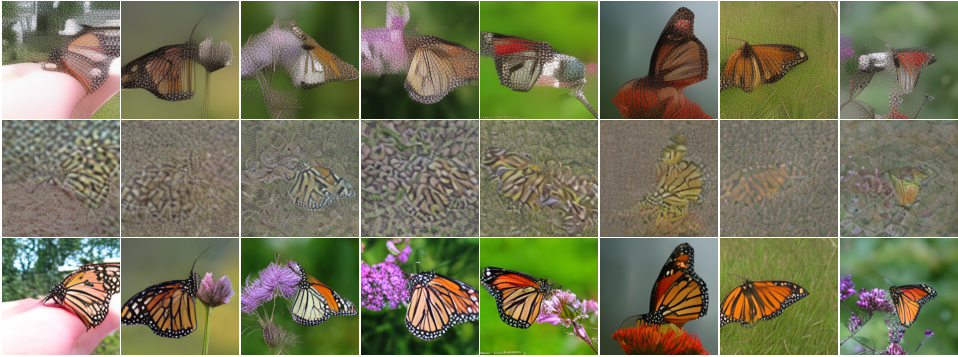

In [6]:
SEED = 0
CLS_IDX = 323
N_SAMPLES = 8
n_row = 2
n_col = N_SAMPLES // n_row

set_seed(SEED)
model.eval()


codes_t, codes_b = sampling_from_hqtransformer(model.stage2,
                                               CLS_IDX,
                                               top_k_s=[2048, 2048],
                                               softmax_temperatures=[0.95, 0.95],
                                               num_candidates=N_SAMPLES,
                                               model_stage1=model.stage1)



pixels_top = torch.clamp(model.stage1.decode_code(codes_t, None) * 0.5 + 0.5, 0, 1)  # [B, 256, 256]
pixels_bot = torch.clamp(model.stage1.decode_code(None, codes_b) * 0.5 + 0.5, 0, 1)  # [B, 256, 256]
pixels_all = torch.clamp(model.stage1.decode_code(codes_t, codes_b) * 0.5 + 0.5, 0, 1)  # [B, 256, 256]
pixels_top = np.transpose(pixels_top.cpu().numpy(), [0, 2, 3, 1])
pixels_bot = np.transpose(pixels_bot.cpu().numpy(), [0, 2, 3, 1])
pixels_all = np.transpose(pixels_all.cpu().numpy(), [0, 2, 3, 1])

fig = plt.figure(figsize=(8*8, 8*3))
for i in range(8):
    ax = fig.add_subplot(3, 8, i+1)
    ax.imshow(pixels_top[i])
    ax.set_axis_off()
for i in range(8):
    ax = fig.add_subplot(3, 8, i+1+8)
    ax.imshow(pixels_bot[i])
    ax.set_axis_off()
for i in range(8):
    ax = fig.add_subplot(3, 8, i+1+16)
    ax.imshow(pixels_all[i])
    ax.set_axis_off()

plt.tight_layout()
plt.show()

### FFHQ - 8x8 + 16x16

In [6]:
RESULT_PATH = ROOT_PATH + 'hqtransformer-layer24-ffhq'
model = load_model(RESULT_PATH, DEVICE)

hparam_dec is None. Use hparam instead.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 35.50it/s]


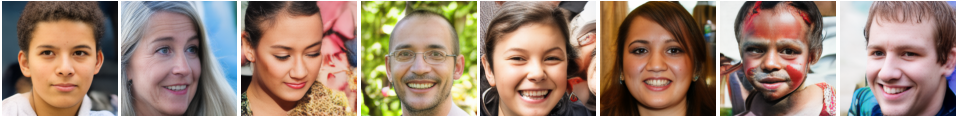

In [9]:
SEED = 1
N_SAMPLES = 8
n_row = 2
n_col = N_SAMPLES // n_row

set_seed(SEED)
model.eval()


codes_t, codes_b = sampling_from_hqtransformer(model.stage2,
                                               None,
                                               top_k_s=[4096, 4096],
                                               softmax_temperatures=[1.0, 1.0],
                                               num_candidates=N_SAMPLES,
                                               model_stage1=model.stage1)



pixels_all = torch.clamp(model.stage1.decode_code(codes_t, codes_b) * 0.5 + 0.5, 0, 1)  # [B, 256, 256]
pixels_all = np.transpose(pixels_all.cpu().numpy(), [0, 2, 3, 1])

fig = plt.figure(figsize=(8*8, 8))
for i in range(8):
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(pixels_all[i])
    ax.set_axis_off()

plt.tight_layout()
plt.show()

### CC15M - 8x8 + 16x16

In [7]:
RESULT_PATH = ROOT_PATH + 'hqtransformer-layer12-cc15m'
model = load_model(RESULT_PATH, DEVICE)

model_clip, preprocess_clip = clip.load("ViT-B/32", device='cuda')

hparam_dec is None. Use hparam instead.


In [11]:
tokenizer = create_tokenizer('bpe16k_huggingface', lowercase=True, dropout=None)
context_length = model.stage2.pos_emb_txt.weight.shape[0]

tokenizer.add_special_tokens(["[PAD]"])
tokenizer.enable_padding(length=context_length,
                              pad_id=tokenizer.token_to_id("[PAD]"))
tokenizer.enable_truncation(max_length=context_length)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 32.68it/s]


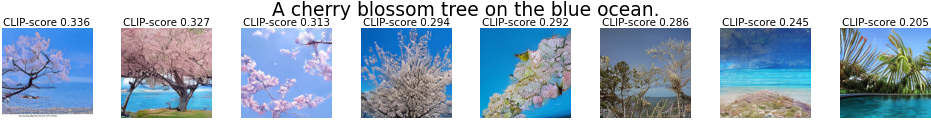

In [16]:
input_txt = "A cherry blossom tree on the blue ocean."

SEED = 0
N_SAMPLES = 8
n_row = 2
n_col = N_SAMPLES // n_row

texts = [input_txt for i in range(0, N_SAMPLES)]

text_list = []
for text in texts:
    text_list.append(encode_text(text, tokenizer, DEVICE))
text = torch.cat(text_list, dim=0)

set_seed(SEED)
model.eval()

codes_t, codes_b = sampling_from_hqtransformer(model.stage2,
                                               text,
                                               top_k_s=[8192, 8192],
                                               top_p_s=[1.0, 1.0],
                                               softmax_temperatures=[0.9, 0.9],
                                               num_candidates=1,
                                               device=DEVICE,
                                               model_stage1=model.stage1)

pixels_all = torch.clamp(model.stage1.decode_code(codes_t, codes_b) * 0.5 + 0.5, 0, 1)  # [B, 256, 256]

pixels_all = np.transpose(pixels_all.cpu().numpy(), [0, 2, 3, 1])

ranked, scores = clip_reranking(pixels_all, texts[0])
pixels_all = pixels_all[ranked]

fig = plt.figure(figsize=(8*8, 8*1))
plt.suptitle(input_txt, fontsize=90, y=1.0)

fig_scores = []
for i in range(8):
    ax = fig.add_subplot(1, 8, i+1)
    ax.imshow(pixels_all[i])
    _score = float(scores[i])
    fig_scores.append(_score)
    plt.title(f'CLIP-score {_score:.3f}', fontsize=50)
    ax.set_axis_off()

plt.tight_layout()
plt.show()